## Setup

In [1]:
import torch
from torch import tensor
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

## Task

Suppose we have a dataset with just a single feature `x` and continuous outcome variable `y`.

In general we're going to be faced with a dataset with an unknown and probably nonlinear relationship. But for now let's use a simple dataset with a known linear relationship:

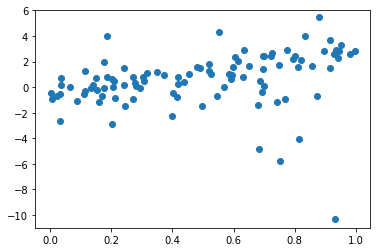

In [17]:
true_weights = 4.0
true_bias = -1.0

# Make the randomness consistent
torch.manual_seed(0)
# Use random x values
x = torch.rand(100)
# Generate random noise, same shape as *x*, that has some outliers.
#noise = torch.randn_like(x)
noise = torch.distributions.studentT.StudentT(2.0).sample(x.shape)
#print(f"Noise mean: {noise.mean()}, noise variance {noise.var()}")
# Generate true y values 
y_true = true_weights * x + true_bias + noise
# Make a scatterplot. The semicolon at the end says to ignore the return value.
plt.scatter(x, y_true); plt.ylim(-11, 6);

In [18]:
bias = 0.0

In [24]:
@widgets.interact(slope=(-5.0, 5.0))
def plot_linreg(slope):
    y_pred = slope * x + bias
    plt.scatter(x, y_true); plt.plot(x, y_pred, 'r');
    resid = y_true - y_pred
    mse = resid.pow(2).mean()
    mae = resid.abs().mean()
    print(f"MSE: {mse}, MAE: {mae}")

interactive(children=(FloatSlider(value=0.0, description='slope', max=5.0, min=-5.0), Output()), _dom_classes=…

- Slope that minimizes MSE: 1.4
- Slope that minimizes MAE: 2.4
- Description of the difference: MAE ignores outliers

### Gradient


Make a function that computes the MSE.

In [29]:
def linreg_mse(slope):
    y_pred = slope * x + bias
    resid = y_true - y_pred
    return resid.pow(2).mean()

In [33]:
linreg_mse(0.0)

tensor(4.9073)

In [31]:
linreg_mse(2.4)

tensor(4.6011)

In [32]:
linreg_mse(1.4)

tensor(4.2745)

Plot the MSE as a function of slope.

In [61]:
slopes = torch.linspace(-1, 2, steps=100)
mse_s = []
for slope in slopes:
    mse_s.append(linreg_mse(slope))
    
@widgets.interact(slope=(-1.0, 2.0))
def plot_tangents(slope):
    plt.plot(slopes, mse_s, label="MSE"); plt.xlabel("slope"); plt.ylabel("MSE");

    # finite difference method for numerically approximating a gradient
    eps = .01
    gradient = (linreg_mse(slope + eps) - linreg_mse(slope)) / eps
    plt.plot(slopes, (slopes - slope) * gradient + linreg_mse(slope), label=f"Tangent line at {slope:.3f}");
    print(gradient)
    plt.ylim(4, 6.5)
    plt.legend();


interactive(children=(FloatSlider(value=0.5, description='slope', max=2.0, min=-1.0), Output()), _dom_classes=…

In [211]:
# finite difference method for numerically approximating a gradient
slope = 0.0
eps = 1e-3
gradient = (linreg_mse(slope + eps) - linreg_mse(slope)) / eps
gradient.item()

-0.9059905409812927

### Gradient Descent

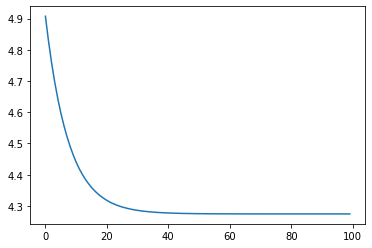

In [203]:
losses = []
slope = 0.0
N_ITER = 100
for i in range(N_ITER):
    loss = linreg_mse(slope)
    gradient = (linreg_mse(slope + eps) - linreg_mse(slope)) / eps
    slope -= .1 * gradient
    #print(f"slope = {slope:.3f}, Loss = {loss:.3f}, gradient = {gradient}")
    losses.append(loss)
plt.plot(losses)

In [204]:
slope

tensor(1.3895)

## PyTorch autograd

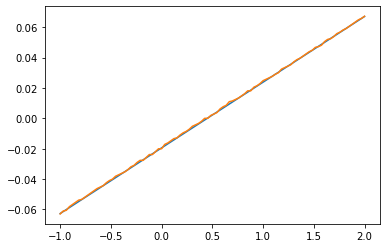

In [225]:
eps = 1e-3
gradients = []
grads_finite_diff = []
for slope in torch.linspace(1.3, 1.5, steps=100):
    slope = torch.tensor(slope.item(), requires_grad=True)
    loss = linreg_mse(slope)
    loss.backward()
    gradients.append(slope.grad.item())
    grads_finite_diff.append(
        (linreg_mse(slope.item() + eps) 
         -
         linreg_mse(slope.item()))
        / (eps))
plt.plot(slopes, gradients)
plt.plot(slopes, grads_finite_diff)